# Предсказание стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.\
Имеем в распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

**Цель проекта:** построить модель для определения стоимости автомобиля. Метрика `RMSE` должна быть меньше **2500**.

*При выборе лучшей модели в первую очередь необходимо учитывать:*
- качество предсказания
- скорость предсказания
- время обучения
<br><br>


**Входные признаки:**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л.с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак:**
- `Price` — цена (евро)
<br><br>

**Основные этапы работ для каждой из задач:**
1. Изучение и предобработка данных.
2. Исследовательский и корреляционный анализ.
3. Удаление лишних входных признаков при необходимости.
4. Подготовка данных к машинному обучению.
5. Построение нескольких моделей.
6. Выбор лучшей модели.

## Библиотеки и функции

In [1]:
# !pip install -U scikit-learn -q
# !pip install phik -q
# !pip install optuna -q
# !pip install optuna_integration -q
# !pip install lightgbm -q
# !pip install catboost -q
# !pip install xgboost -q

In [2]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import phik
import warnings

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import optuna
from optuna_integration import OptunaSearchCV
from optuna import distributions as opt_dis


optuna.logging.set_verbosity(optuna.logging.WARNING) # Отключение информационных сообщений optuna
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None) # Отображение неограниченного количества столбцов в таблицах
#pd.set_option('display.max_colwidth', None)  # Снятие ограничения на максимальную длину строки в таблице
#pd.set_option('display.max_rows', None) # Отображение неограниченного количества строк в таблица

In [3]:
# Функция для отрисовки пары boxplot и histplot
def chart_box_hist(data, columns, title=None, bins=30, hue=None):
    s = len(columns)
    fig = plt.subplots(s, 2, figsize=(14, s * 3.5))
    plt.suptitle(title, fontsize=14, fontweight='bold', y=.92)
    for i, col in zip(range(1, s + 1), columns):
        data_group_shape = data.groupby(col)[col].count().shape[0]
        bins_ = bins if data_group_shape >= bins else data_group_shape

        ax1 = plt.subplot(s, 2, i*2 - 1)
        ax2 = plt.subplot(s, 2, i*2)

        sns.boxplot(data=data, x=col, y=hue, boxprops={'alpha': .6}, ax=ax1)
        ax1.set(title=col, xlabel='', ylabel='')
        sns.histplot(data=data, x=col, hue=hue, kde=True, bins=bins_, ax=ax2, legend=True) #multiple="stack", stat='density', common_norm=False
        ax2.set(title=col, xlabel='', ylabel='')

        if not hue:
            df = data[col]
            ax2.axvline(x=df.median(), color='black', alpha=.6, label=f'median ({df.median():.2f})')
            ax2.axvline(x=df.mean(),   color='black', alpha=.6, label=f'mean ({df.mean():.2f})', linestyle='dashed')
        else:
            for i, hu in enumerate(data[hue].unique()):
                df = data[data[hue] == hu][col]
                ax2.axvline(x=df.mean(), alpha=1, linewidth=1.5, color=plt.cm.tab10.colors[i], label=f'mean {hue} - {hu} ({df.mean():.2f})', linestyle='dashed')
                
        ax2.legend(bbox_to_anchor=(1.05 , 1), loc='upper left', borderaxespad=0)
    plt.show()

In [4]:
# Функция для отрисовки круговых диаграмм
def chart_pie(data, col, ax, title=None, max_item=9):
    group = data[col].value_counts()
    
    if not title:
        title = col

    if len(group) > max_item:
        group = pd.concat([group[:max_item], pd.Series(group[max_item:].sum(), index=[f'other ({len(group[max_item:])})'])])
        
    ax.pie(
        x=group,
        labels=group.index,
        autopct='%.1f%%', 
        startangle = 90,
        pctdistance=.8, 
        wedgeprops={'width': .4}, 
        colors=sns.color_palette('pastel')
    )
    ax.text(
        0, 0, title, #.replace('_', '\n'), 
        horizontalalignment='center', 
        verticalalignment='center', 
        fontweight='bold',
        fontsize = 10
    )
    ax.set(title='', xlabel='', ylabel='')

In [5]:
# Функция для вывода матрицы корреляции
def corr_matrix(matrix):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt='.2f', cmap='Blues', ax=ax)
    ax.set_title('correlation $\phi_K$', fontsize=14, fontweight='bold')
    plt.show()

In [6]:
# Интерпретация коэффициентов корреляции по шкале Чеддока
def corr_interpretation(coef):
    try:
        if coef < 0.1:
            return 'осутствует'
        elif 0.1 <= coef < 0.3:
            return 'слабая'
        elif 0.3 <= coef < 0.5:
            return 'умеренная'
        elif 0.5 <= coef < 0.7:
            return 'заметная'
        elif 0.7 <= coef < 0.9:
            return 'высокая'
        elif 0.9 <= coef < 0.95:
            return 'весьма высокая'
        else:
            return 'наблюдается мультиколлинеарность'
    except:
        pass

In [7]:
# Функция для вывода отсортированной таблицы коэффициентов корреляции
def corr_sort(matrix):
    corr = (
        matrix
        .abs()
        .stack()
        .reset_index()
        .rename(columns={0: "corr", 'level_0': 'feature_1', 'level_1': 'feature_2'})
        .query('feature_1 != feature_2')
        .sort_values(by='corr', ascending=False)
        .loc[::2]
        .reset_index(drop=True)
    )
    corr['interpretation'] = corr['corr'].apply(corr_interpretation)
    return corr

In [8]:
# Функция для вывода коэффициентов целевого признака
def target_corr(matrix, col):
    target_corr = pd.DataFrame(matrix[col].abs().drop(col).sort_values(ascending=False))
    target_corr.columns = ['corr']
    target_corr['interpretation'] = target_corr['corr'].apply(corr_interpretation)
    return target_corr

## Загрузка данных

In [9]:
data = pd.read_csv('/datasets/autos.csv')

for i in ['DateCrawled', 'DateCreated', 'LastSeen']:
    data[i] = pd.to_datetime(data[i])

Вывод первых строк таблицы:

In [10]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Основная информация о датафрейме:

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Подсчитаем, количество пропусков в каждой колонке, а так же их процент

In [12]:
print('Всего строк:', data_shape_before := data.shape[0])

pd.DataFrame({'percent': round(data.isna().mean()*100, 1), 'sum': data.isna().sum()}).style.background_gradient('Blues')

Всего строк: 354369


,percent,sum
DateCrawled,0.000000,0
Price,0.000000,0
VehicleType,10.600000,37490
RegistrationYear,0.000000,0
Gearbox,5.600000,19833
Power,0.000000,0
Model,5.600000,19705
Kilometer,0.000000,0
RegistrationMonth,0.000000,0
FuelType,9.300000,32895


**Вывод:** данные в датафрейме соответствуют описанию. Тип данных всех признаков выставлен корректный.\
Следующие признаки имеют пропуски:
- `VehicleType` — тип автомобильного кузова
- `Gearbox` — тип коробки передач
- `Model` — модель автомобиля
- `FuelType` — тип топлива
- `Repaired` — была машина в ремонте или нет

Отметим, что все признаки, имеющие пропуски, относятся к категориальному типу.

## Предобработка данных

Приведем названия столбцов к **snake_case**

In [13]:
def to_snake_case(name):
    return re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower()


for col in data.columns:
    data = data.rename(columns={col:to_snake_case(col)})


# Проверка
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

**Вывод:** названия признаков успешно преобразованы

Рассмотрим признаки, содержащие дату и время:

In [14]:
for i in ['date_crawled', 'date_created', 'last_seen']:
    min = data[i].dt.date.min()
    max = data[i].dt.date.max()
    print(f'{i+":":<13} [{min} - {max}]  delta = {(max - min).days:>3} days')

date_crawled: [2016-03-05 - 2016-04-07]  delta =  33 days
date_created: [2014-03-10 - 2016-04-07]  delta = 759 days
last_seen:    [2016-03-05 - 2016-04-07]  delta =  33 days


Диапазон дат скачивания анкет из базы `date_crawled` и дат последней активности пользователя `last_seen` совпадает. Из этого можем сделать вывод, что срез данных, проводимый с **5 марта** по **7 апреля** 2016 года затрагивал только активных пользователей.

Рассмотрим, в какие года и месяца выкладывались объявления:

In [15]:
print(data['date_created'].dt.to_period("M").value_counts().sort_index())

print('\nКоличество объявлений, выложенных до 2016 года:', data[data['date_created'].dt.year < 2016].shape[0])

date_created
2014-03         1
2015-03         1
2015-06         1
2015-08         2
2015-09         3
2015-11         9
2015-12         9
2016-01        70
2016-02       397
2016-03    296757
2016-04     57119
Freq: M, Name: count, dtype: int64

Количество объявлений, выложенных до 2016 года: 26


Основная масса объявлений опубликована в марте и апреле 2016 года. До 2016 выставлено только 26 объявлений, можем смело их удалить, так как они достаточно долго висят в продаже (возможно владельцы выставили цены сильно выше рынка)

In [16]:
rows_before = data.shape[0]

data = data.drop(data[data['date_created'].dt.year < 2016].index)

print('Количество удаленных строк:', rows_before - data.shape[0])

Количество удаленных строк: 26


**Вывод:** объявления, опубликованные до 2016 года успешно удалены.

Рассмотрим признак `registration_year` - год регистрации автомобиля.

In [17]:
data.describe()['registration_year']

count    354343.000000
mean       2004.234496
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
std          90.231247
Name: registration_year, dtype: float64

Видим, что в данных присутствуют строки с аномально высокими и низкими значениями года регистрации авто. Посчитаем, сколько строк содержат год менее, чем 1950 и более, чем 2016 (год среза данных):

In [18]:
print(data[data['registration_year'] < 1950].shape[0])
print(data[data['registration_year'] > 2016].shape[0])

246
14530


Объявлений, год регистрации авто в которых установлен 2017 и выше, довольно много - 14.5к. Посмотрим, по каким годам распределены эти объявления.

In [19]:
data[data['registration_year'] > 2016]['registration_year'].value_counts().head(10)

registration_year
2017    10441
2018     3959
9999       26
2019       25
5000       17
3000        7
6000        5
7000        4
2500        4
4000        3
Name: count, dtype: int64

В основном в этих объявлениях год регистрации установлен как 2017 и 2018. Рассмотрим несколько случайных объявлений, где год регистрации указан 2017

In [20]:
data[data['registration_year'] == 2017].sample(5, random_state=42)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
69589,2016-03-09 07:53:41,15300,NaN,2017,auto,450,cayenne,150000,0,NaN,porsche,no,2016-03-09,0,78120,2016-03-17 21:16:25
147783,2016-03-31 20:49:35,2000,NaN,2017,manual,74,passat,150000,0,NaN,volkswagen,NaN,2016-03-31,0,99310,2016-03-31 20:49:35
136129,2016-03-10 19:39:32,8500,NaN,2017,manual,105,touran,125000,3,NaN,volkswagen,no,2016-03-10,0,41468,2016-03-16 09:17:20
339947,2016-03-25 18:58:06,1199,NaN,2017,NaN,0,corsa,150000,0,petrol,opel,NaN,2016-03-25,0,44145,2016-04-01 04:18:13
9506,2016-04-02 22:53:05,5000,NaN,2017,manual,204,golf,150000,0,petrol,volkswagen,no,2016-04-02,0,32339,2016-04-07 01:46:27


Рассмотрим пробеги автомобилей, с годом регистрации 2017:

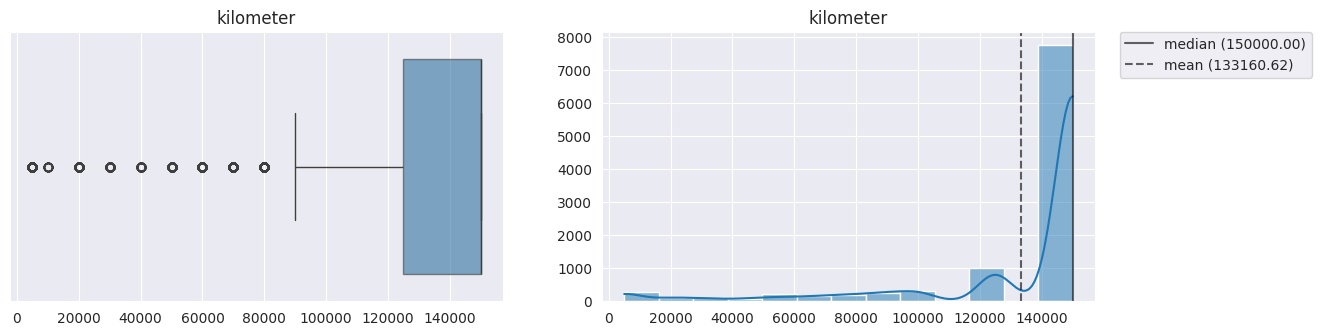

In [21]:
chart_box_hist(data[data['registration_year'] == 2017], ['kilometer'])

Напомню, мы имеем срез данных, где дата размещения самого свежего объявления - это апрель 2016 года. На графиках мы видим, что у автомобилей с годом регистрации 2017 большинство пробегов выше 130к км. Здесь имеет место явная ошибка.\
Хорошим решением будет удалить эти данные, так как стоимость автомобиля очень сильно определяется годом начала эксплуатации. Эти данные будут вносить неточности в модель.\
Удалим, все объявления, где год регистрации выставлен до 1950 и после 2016

In [22]:
rows_before = data.shape[0]

data = data.drop(data.query('not 1950 <= registration_year <= 2016').index)

print('Количество удаленных строк:', rows_before - data.shape[0])

Количество удаленных строк: 14776


**Вывод:** успешно удалено 14776 объявлений.

### Проверка наличия неявных дубликатов

In [23]:
for col in data.select_dtypes(include='object').columns.tolist():
    print(f'{col}:', sorted(data[col].dropna().unique()), '\n')

vehicle_type: ['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon'] 

gearbox: ['auto', 'manual'] 

model: ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino',

В признаках `vehicle_type`, `model`, `fuel_type` помимо пропущенных значений **NaN** присутствуют значения **other**. Эи два значения мы можем приравнять, так как за other может скрываться все что угодно.

In [24]:
for col in ['vehicle_type', 'model', 'fuel_type']:
    data[col] = data[col].replace('other', np.nan)

В признаке `fuel_type` значения **gasoline** и **petrol** означают бензин; первое название в ходу в Америке, а второе в Англии. Приравняем их и оставим только **gasoline**.

In [25]:
data['fuel_type'] = data['fuel_type'].replace('petrol', 'gasoline')

**Вывод:** неявные дубликаты в признаке `fuel_type` успешно устранены. В признаке, содержащим название моделей возможно есть дубликаты, но на глаз их обнаружить не удалось. В остальных колонках дубликаты отсутствуют.\
Так же значения **other** заменены на **NaN**.

### Заполнение пропусков в категориальных признаках

Посмотрим, сколько мы имеем пропусков на данный момент

In [26]:
pd.DataFrame({'percent': round(data.isna().mean()*100, 1), 'sum': data.isna().sum()}).query('sum > 0').style.background_gradient('Blues')

,percent,sum
vehicle_type,7.700000,26103
gearbox,5.200000,17810
model,12.200000,41353
fuel_type,8.100000,27352
repaired,19.000000,64674


Пропуски в названии модели автомобиля заполнить проблематично, поэтому все строки, где отсутствует значение признака `model` мы удалим.

In [27]:
rows_before = data.shape[0]

data = data.dropna(subset=['model'])

print('Количество удаленных строк:', rows_before - data.shape[0])


pd.DataFrame({'percent': round(data.isna().mean()*100, 1), 'sum': data.isna().sum()}).query('sum > 0').style.background_gradient('Blues')

Количество удаленных строк: 41353


,percent,sum
vehicle_type,6.300000,18915
gearbox,4.300000,12894
fuel_type,6.600000,19557
repaired,17.700000,52684


Пропуски в признаках `vehicle_type`, `gearbox`, `fuel_type` заполним самым частым значением для комбинации бренда и модели. Для этого создадим вспомогательную таблицу с уникальными комбинациями названий.

In [28]:
# создаем сводную таблицу data_pivot_1, где содержатся уникальные комбинации бренда и модели
# и самые часто встречающиеся значения для признаков (мода)
data_pivot_1 = data.pivot_table(
    index=['brand', 'model'], 
    aggfunc={
        'vehicle_type': pd.Series.mode, 
        'gearbox': pd.Series.mode, 
        'fuel_type': pd.Series.mode}
    ).copy().reset_index()

data_pivot_1.head()

,brand,model,fuel_type,gearbox,vehicle_type
0,alfa_romeo,145,gasoline,manual,small
1,alfa_romeo,147,gasoline,manual,sedan
2,alfa_romeo,156,gasoline,manual,wagon
3,alfa_romeo,159,gasoline,manual,wagon
4,alfa_romeo,spider,gasoline,manual,convertible


Заполняем пропуски в основной таблице самыми частыми значениями для каждой комбинации бренда и модели

In [29]:
%%time

for i in data_pivot_1.index:
    brand = data_pivot_1.loc[i, 'brand']
    model = data_pivot_1.loc[i, 'model']
    for col in ['vehicle_type', 'gearbox', 'fuel_type']:
        feature = data_pivot_1.loc[i, col]
        # если модой являются 2 и более значения, то выбираем первое из списка
        if isinstance(feature, np.ndarray):
            feature = feature[0]
        data.loc[(data['brand'] == brand) & (data['model'] == model) & (data[col].isna()), col] = feature
        # data.loc[(data['brand'] == brand) & (data['model'] == model), col] = \
        # data.loc[(data['brand'] == brand) & (data['model'] == model), col].fillna(feature)
        

pd.DataFrame({'percent': round(data.isna().mean()*100, 1), 'sum': data.isna().sum()}).loc[['vehicle_type', 'gearbox', 'fuel_type'], :].style.background_gradient('Blues')

CPU times: user 22.1 s, sys: 0 ns, total: 22.1 s
Wall time: 22.1 s


,percent,sum
vehicle_type,0.000000,0
gearbox,0.000000,0
fuel_type,0.000000,0


Пропуски в столбце `repaired` (была машина в ремонте или нет) заполним заглушкой. Это будет равносильно тому, что информации о повреждении машины нет.

In [30]:
data['repaired'] = data['repaired'].fillna('undefined')

**Вывод:** мы успешно избавились от пропусков в категориальных признаках.

### Исправление значений в количественных признаках

Рассмотрим распределение числовых признаков

In [31]:
data.describe()

,date_crawled,price,registration_year,power,kilometer,registration_month,date_created,number_of_pictures,postal_code,last_seen
count,298214,298214.000000,298214.000000,298214.000000,298214.000000,298214.000000,298214,298214.0,298214.000000,298214
mean,2016-03-21 13:02:44.133870080,4565.033043,2002.983348,112.048019,128842.911466,5.864423,2016-03-20 19:32:28.375327744,0.0,50807.576127,2016-03-30 00:12:18.137230336
min,2016-03-05 14:06:22,0.000000,1950.000000,0.000000,5000.000000,0.000000,2016-01-02 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:42:08.249999872,1180.000000,1999.000000,71.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30539.000000,2016-03-23 03:49:55
50%,2016-03-21 17:51:28,2900.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49635.000000,2016-04-03 16:10:30
75%,2016-03-29 14:49:09.500000,6600.000000,2007.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71334.000000,2016-04-06 10:16:04
max,2016-04-07 14:36:58,20000.000000,2016.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4549.710045,6.100180,184.128530,36805.811421,3.672959,NaN,0.0,25720.532936,NaN


- `price` - имеет аномальные значения, равные нулю.
- `registration_year` - с данным признаком все в порядке - его значения мы обработали выше
- `power` - в столбце с мощностью двигателя присутствуют аномально высокие и аномально низкие значения - от 0 до 20000.
- `kilometer` - данные по пробегам на первый взгляд адекватные.
- `registration_month` - в столбце с месяцем регистрации присутствуют нулевые значения.
- `number_of_pictures` - признак имеет только нулевые значения. Его можно смело удалять.
- `postal_code` - почтовый индекс пользователя - данный признак, скорее всего будет бесполезным для модели. Но мы его пока оставим.

Посмотрим, какое количество нулевых значений содержит признак `registration_month`

In [32]:
print(f"{data.loc[data['registration_month'] == 0, 'registration_month'].count()} {data.loc[data['registration_month'] == 0, 'registration_month'].count() / data.shape[0] * 100:.2f}%")

25479 8.54%


8.5% датасета имеет нулевое значение месяца регистрации. Лучшим решением будет удалить данный признак, так как, во первых, восстановить нулевые значения не представляется возможным; а во вторых, сезонность не должна влиять на стоимость авто.\
Так же удалим `number_of_pictures` - данный признак содержит только нулевые значения.\
Для дальнейшей работы признаки, содержащие даты нам больше не понадобятся - их так же удалим.

In [33]:
data = data.drop(['date_crawled', 'date_created', 'last_seen', 'number_of_pictures', 'registration_month'], axis=1)

data.head(0)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code


Признак `power` содержит явные аномалии от 0 до 20000.\
Для начала заменим на пропуски все значения ниже 26 л.с. и выше 600 л.с. За нижнюю границу примем такой автомобиль, как **Trabant 601**, который мог иметь мотор в 26 л.с. За верхнюю границу возьмем такие автомобили, как **Jaguar s-type, Audi a6, Mercedes Benz S klasse**, которые если не в стоке, то при чип-тюнинге и доработках могут иметь подобную мощность. Все что выходит за эти границы имеет высокую вероятность быть ошибкой.

In [34]:
print('Нижняя граница:')
display(data.loc[data['power'] < 27, ['brand', 'model', 'power']].sort_values(by='power', ascending=False).head(10))
print('\n')
print('Верхняя граница:')
data.loc[data['power'] > 599, ['brand', 'model', 'power']].sort_values(by='power').head(10)

Нижняя граница:


,brand,model,power
140293,trabant,601,26
172741,trabant,601,26
188633,trabant,601,26
326941,trabant,601,26
218071,trabant,601,26
263834,trabant,601,26
307339,trabant,601,26
297237,trabant,601,26
142103,trabant,601,26
231390,trabant,601,26




Верхняя граница:


,brand,model,power
162460,jaguar,s_type,600
146339,jaguar,s_type,600
13373,jaguar,s_type,600
151744,audi,a6,600
243042,mercedes_benz,s_klasse,600
43600,audi,a6,600
180840,volkswagen,polo,601
42521,seat,arosa,601
331252,volkswagen,polo,601
227383,volkswagen,golf,603


Заменяем значения мощности, выходящие за границы **[26, 600]** на пропуски:

In [35]:
data.loc[(data['power'] < 26) | (data['power'] > 600), 'power'] = np.nan

Создаем сводную таблицу, и для каждой уникальной комбинации бренда и модели считаем медианную мощность

In [36]:
data_pivot_2 = data.pivot_table(
    index=['brand', 'model'], 
    aggfunc={'power': 'median'}
    ).copy().reset_index()

data_pivot_2.head()

,brand,model,power
0,alfa_romeo,145,103.0
1,alfa_romeo,147,120.0
2,alfa_romeo,156,150.0
3,alfa_romeo,159,170.0
4,alfa_romeo,spider,150.0


Заполняем пропуски рассчитанной медианой

In [37]:
%%time

for i in data_pivot_2.index:
    brand = data_pivot_2.loc[i, 'brand']
    model = data_pivot_2.loc[i, 'model']
    feature = data_pivot_2.loc[i, 'power']
    data.loc[(data['brand'] == brand) & (data['model'] == model) & (data['power'].isna()), 'power'] = feature

CPU times: user 5.56 s, sys: 0 ns, total: 5.56 s
Wall time: 5.56 s


Проверяем, остались ли пропуски в признаке `power`

In [38]:
data[data['power'].isna()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code
234296,3800,wagon,1978,manual,NaN,serie_1,30000,gasoline,land_rover,undefined,49824
280216,0,wagon,1970,manual,NaN,serie_1,100000,gasoline,land_rover,undefined,88634


Land Rover Series 1 (в изначальном названии **serie_1** в конце слова пропущена **s**) - первый автомобиль компании, уже сильно устаревший. В исходном датасете так же было представлено всего две позиции с данным авто, в колонке с мощностью изначально был ноль. Так как данный автомобиль устаревший и редкий, мы просто удалим эти две строки.

In [39]:
rows_before = data.shape[0]

data = data.drop(data.query('model == "serie_1"').index)

print('Количество удаленных строк:', rows_before - data.shape[0])

Количество удаленных строк: 2


Рассмотрим целевой признак `price`. В нем так же присутствуют нулевые значения

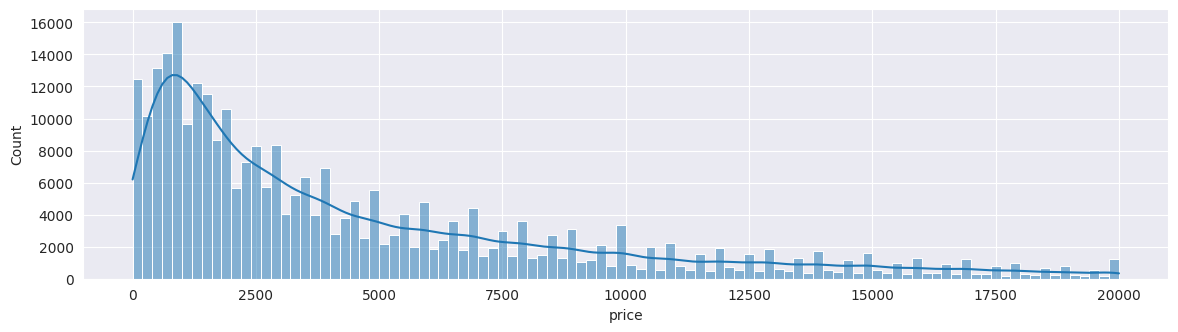

In [40]:
fig, ax = plt.subplots(figsize=(14, 3.5))
sns.histplot(data=data, x='price', kde=True, bins=100, ax=ax)
plt.show()

Определим границу цены, ниже которой значение будем считать аномалией, как 2% квантиль всех цен, исключая нулевые значения. Все аномально низкие значения удалим.

In [41]:
price_quantile = data.loc[data['price'] > 0, 'price'].quantile(.02)
print('Граница цены, ниже которой все объявления будут удалены:', price_quantile)


rows_before = data.shape[0]

data = data[data['price'] >= price_quantile]

print('Количество удаленных строк:', rows_before - data.shape[0])

Граница цены, ниже которой все объявления будут удалены: 200.0
Количество удаленных строк: 12458


**Вывод:** в количественных признаках успешно удалены аномалии. Где было возможно - значения заменены на корректные. Где не было возможности восстановить адекватные значения - такие наблюдения удалены.

### Проверка наличия явных дубликатов

In [42]:
data.duplicated().sum()

21555

Удаляем явные дубликаты

In [43]:
data = data.drop_duplicates()

# проверка
data.duplicated().sum()

0

**Вывод:** явные дубликаты успешно удалены.

Посчитаем, сколько наблюдений осталось в датафрейме и сколько мы удалили при обработке

In [44]:
pd.Series({
    'Количество наблюдений до обработки': data_shape_before,
    'Количество наблюдений после обработки': data.shape[0],
    'Наблюдений удалено': data_shape_before - data.shape[0],
    'Процент удаленных наблюдений': (data_shape_before - data.shape[0]) / data_shape_before * 100
})

Количество наблюдений до обработки       354369.000000
Количество наблюдений после обработки    264199.000000
Наблюдений удалено                        90170.000000
Процент удаленных наблюдений                 25.445228
dtype: float64

Во время предобработки данных было отброшено около 25.5% исходного датасета

## Исследовательский анализ данных

### Распределение числовых признаков

In [45]:
# Сформируем списки с числовыми и категориальными признаками
num_col = data.select_dtypes(include='number').columns.tolist()
cat_col = data.select_dtypes(exclude='number').columns.tolist()

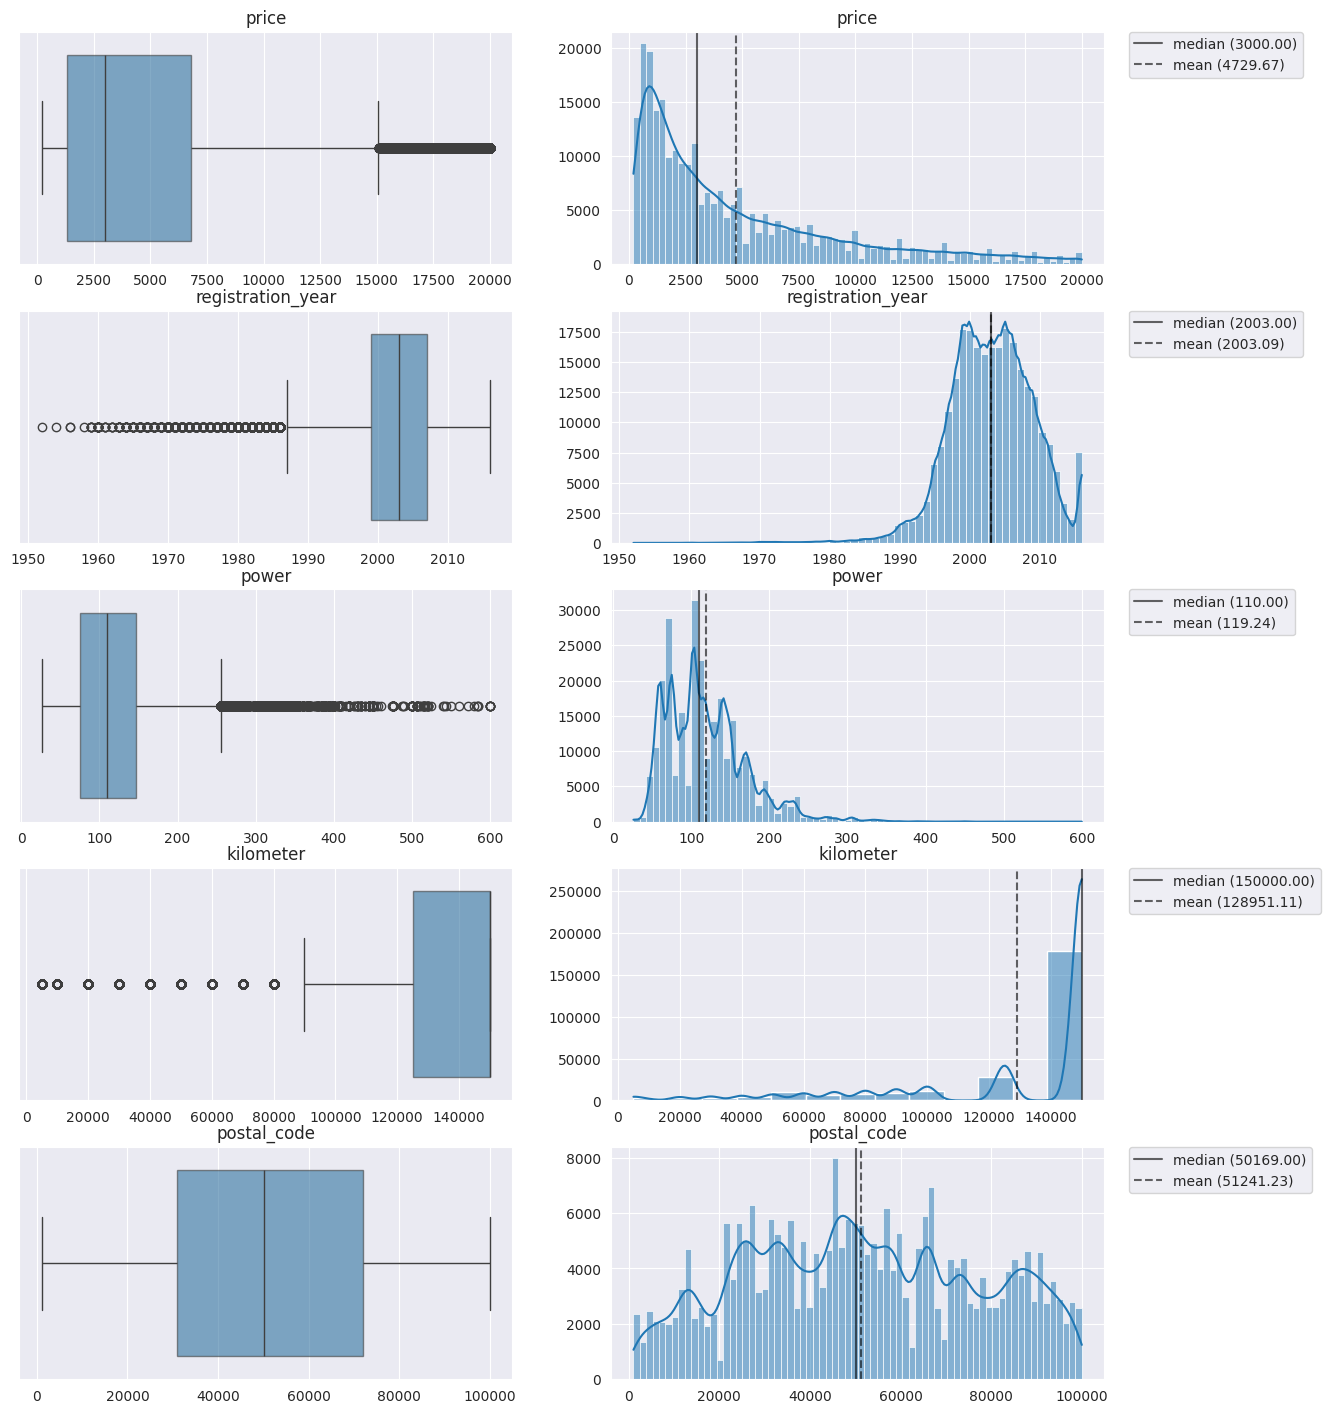

In [46]:
chart_box_hist(data, num_col, bins=70)

**Вывод:** 
1. График распределения целевого признака `price` сильно смещен влево и напоминает распределение Пуассона. Разница между медианой и средним значением довольно велика, и составляет 1729 евро.
2. График для `registration_year` похож на бимодальное распределение со смещением в право. Первый пик приходится примерно на 2000 год, второй - на 2006. Затем до 2015 года наблюдается постоянное уменьшение количества представленных в продаже автомобилей. Но новых автомобилей 2016 года регистрации заметно больше, чем нескольких предыдущих годов. Смещение графика вправо вызвано тем, что в датасете практически отсутствуют автомобили, выпущенные до 1985 года. Медиана и среднее значение почти совпадают, и отличаются всего на 0.1.
3. `Можность` большинства автомобилей приходится на промежуток, примерно от 60 до 250 л.с. Медиана и среднее значение довольно близки, и составляют 110 и 119 л.с.
4. График, описывающий распределение `пробегов` представляет собой дискретное распределение. Значения в датасете даны с большим округлением - в основном в 10 тыс.км, а при больших пробегах в 25тыс.км. Медиана получилась равна максимальному значению в 150тыс.км., т.к. автомобилей этой категории больше чем всех остальных вместе взятых.
5. График `postal_code` стоит воспринимать скорее как категориальный признак с большим количеством категорий. Вероятно эти почтовые индексы принадлежат Германии.

### Распределение категориальных признаков

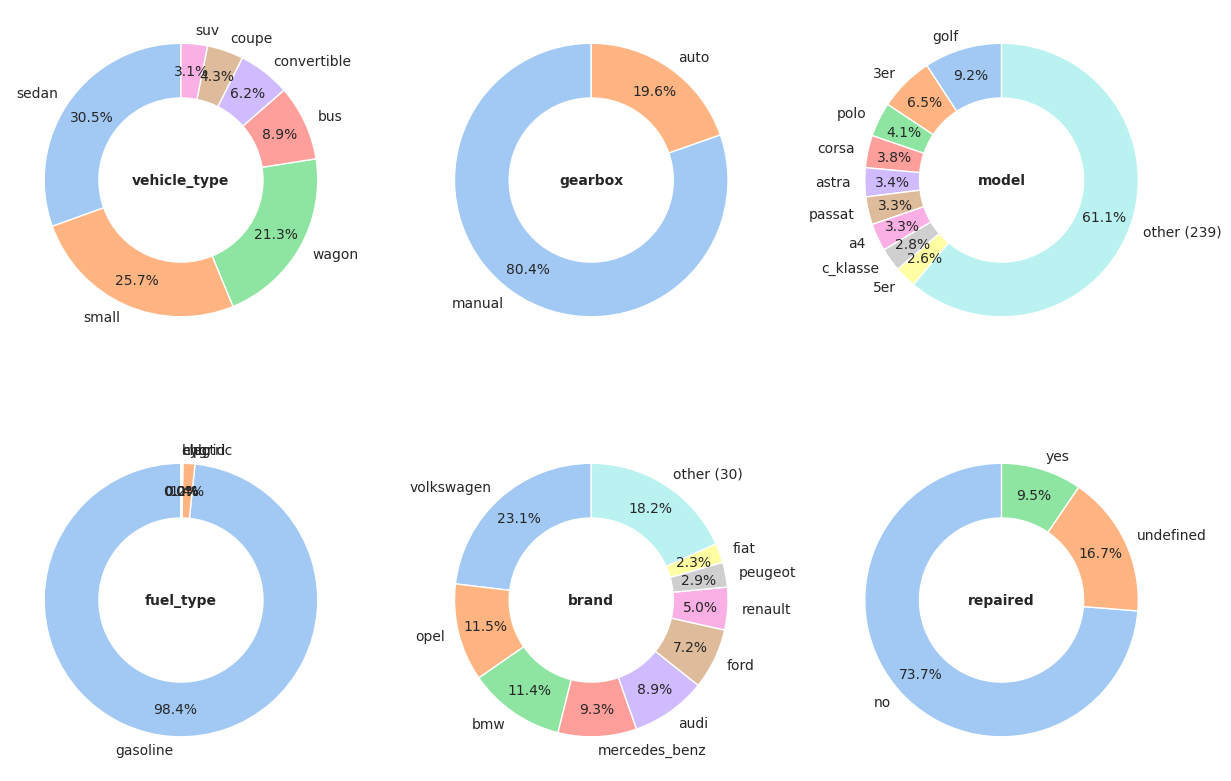

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, col in zip(axes.flat, cat_col):
    chart_pie(data, col, ax)

plt.show()

Отдельно посчитаем количество объявлений, в зависимости от типа топлива, так как на диаграмме бензин сильно перевесил остальные типы

In [48]:
data['fuel_type'].value_counts()

fuel_type
gasoline    259868
lpg           3748
cng            441
hybrid         118
electric        24
Name: count, dtype: int64

**Вывод:**
1. Наиболее распространенные типы кузовов - **sedan**, **small**, **wagon**. Они занимают **более 75%** всех объявлений.
2. Среди типов коробок передач преобладают **ручные**, таких **более 80%**.
3. Самыми распространенными моделями автомобилей являются - **Volkswagen Golf**, **BMW 3 series** и **Volkswagen Polo**
4. Подавляющее большинство автомобилей работают на бензине. Иные типы топлива используются лишь на **1.6%** автомобилей. Так как в данном признаке наблюдается значительный дисбаланс (почти весь датасет описывается одной категорией), то использовать его при обучении моделей будет бессмысленно. Поэтому его можно удалить.
5. Пять самых крупных автобрендов являются немецкими, занимая практически **2/3** рынка. Самый распространенный - **Volkswagen** представлен **более чем в 23%** объявлений.
6. Около **9.5%** автомобилей в объявлениях были в ремонте. Почти **3/4** автомобилей битыми небыли. Судьба оставшихся **16.7%** авто остается под вопросом, так как в части объявлений данная информация не была указана.

Удаляем признак `fuel_type`

In [49]:
data = data.drop(['fuel_type'], axis=1)

### Корреляционный анализ

Рассмотрим корреляцию признаков. Опираться будем на коэффициент фи.

In [50]:
phik_overview = data.phik_matrix(interval_cols=num_col)

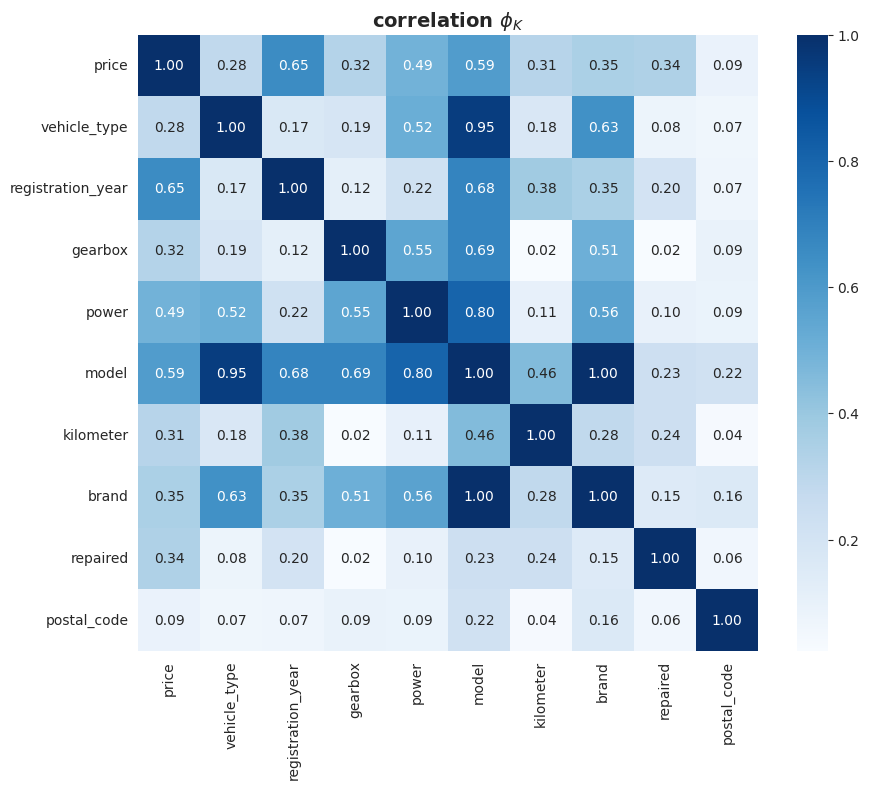

Наибольшие коэффициенты корреляции:


,feature_1,feature_2,corr,interpretation
0,brand,model,0.999828,наблюдается мультиколлинеарность
1,vehicle_type,model,0.949093,весьма высокая
2,model,power,0.801792,высокая
3,model,gearbox,0.685239,заметная
4,registration_year,model,0.684532,заметная
5,registration_year,price,0.654653,заметная
6,vehicle_type,brand,0.634286,заметная
7,price,model,0.591351,заметная
8,brand,power,0.564212,заметная
9,gearbox,power,0.552070,заметная


In [51]:
corr_matrix(phik_overview)

print('Наибольшие коэффициенты корреляции:')
corr_sort(phik_overview).head(10)

Рассмотрим отдельно корреляцию целевого признака

In [52]:
target_corr(phik_overview, 'price')

,corr,interpretation
registration_year,0.654653,заметная
model,0.591351,заметная
power,0.494423,умеренная
brand,0.351326,умеренная
repaired,0.336753,умеренная
gearbox,0.321282,умеренная
kilometer,0.313583,умеренная
vehicle_type,0.283830,слабая
postal_code,0.091810,осутствует


**Вывод:** у признака `model` присутствует мультиколлинеарная связь с `brand` и `vehicle_type`. Хорошим решением будет удалить лишь один признак - `model`, что бы он не конфликтовал с двумя другими. В ходе экспериментов так же комбинация признаков `brand` и `vehicle_type` показала лучшую точность в сравнении с одним `model`.\
Признак `postal_code` так же можно удалить, потому что он очень слабо коррелирует с ценой. 

In [53]:
data = data.drop(['model', 'postal_code'], axis=1)

## Обучение моделей

In [54]:
RANDOM_STATE = 42
target = 'price'

# Отделяем таргет от входных признаков
X = data.drop(target, axis=1)
y = data[target]

# Формируем списки из названий числовых и категориальных признаков
num_col = X.select_dtypes(include='number').columns.tolist()
cat_col = X.select_dtypes(exclude='number').columns.tolist()

# Разделяем датасет на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=.2, 
    random_state=RANDOM_STATE
)


# Для отладки:
# X_train = X_train.sample(15000, random_state=RANDOM_STATE)
# y_train = y_train.loc[X_train.index]

In [55]:
# Пайплайн для масштабирования количественных и кодирования категориальных признаков. 
data_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_col),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_col)
])

In [56]:
# Объявим датафрейм, в который будем заносить результаты протестированных моделей
rating_model_df = pd.DataFrame(columns=['Search params (sec)', 'Fit (sec)', 'Predict (sec)', 'RMSE'])

In [57]:
# Функция автоматизированного подбора гиперпараметров
def optuna_search_cv(model, param_distributions, X, y):
    estimator = Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', model)])

    # Подбор параметров и кросс-валидацию будем осуществлять с помощью байесовской оптимизации
    # из модуля Optuna
    optuna_search = OptunaSearchCV(
        estimator, 
        param_distributions, 
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=RANDOM_STATE,
        n_trials=25
    )

    # Время выполнения следующих операция заносится в датафрейм
    # Подбор параметров и кросс-валидация
    start = time.time()
    optuna_search.fit(X, y)
    search_time = time.time() - start

    # Обучение лучшей модели
    start = time.time()
    optuna_search.best_estimator_.fit(X_train, y_train)
    time_fit = time.time() - start

    # Предсказание лучшей модели
    start = time.time()
    optuna_search.best_estimator_.predict(X_test)
    time_predict = time.time() - start


    # Формируем список из временных значений и метрики качества
    result = [search_time, time_fit, time_predict, optuna_search.best_score_ * -1]
    # Получаем название текущей модели
    model_name = optuna_search.best_estimator_[1].__class__.__name__
    # Заносим значения в датафрейм, округляя числа
    rating_model_df.loc[model_name] = [round(x, 2) for x in result]

    # функция возвращает объект OptunaSearchCV с обученной лучшей моделью
    return optuna_search

In [58]:
# Функция для вывода параметров лучшей модели
def optuna_result(optuna_search, view_table=True):
    # Получаем название текущей модели
    model_name = optuna_search.best_estimator_[1].__class__.__name__
    
    print(f'{model_name} best parameters:')
    # Каждый гиперпараметр печатаем с новой строки, убирая в названии приписку 'model__' от пайплайна
    for i, j in optuna_search.best_params_.items():
        print(f'{i[7:]}: {j}')

    if view_table:
        print()
        # Из датафрейма rating_model_df извлекаем данные для текущей модели по индексу (названию модели)
        display(rating_model_df.loc[[model_name]])

    # Для отладки
    #display(optuna_search.trials_dataframe())

### Constant model - **DummyRegressor**

В качестве начальной точки отсчета для оценки моделей применим константную модель **DummyRegressor**; для каждого объекта в качестве предсказания она всегда выдает среднее значение цены.

In [59]:
dummy_model = DummyRegressor(strategy='mean').fit(X_train, y_train)

print(f'RMSE на тренировочной выборке: {mean_squared_error(y_train, dummy_model.predict(X_train)) ** .5:.2f}')

RMSE на тренировочной выборке: 4538.48


### Baseline model - **LinearRegression**

За базовую модель возьмём линейную регрессию. С ее метрикой качества будем сравнивать более сложные модели

In [60]:
cross_val_lr = cross_val_score(
    LinearRegression(), 
    data_preprocessor.fit_transform(X_train), 
    y_train, 
    scoring='neg_root_mean_squared_error').mean()

print(f'RMSE на тренировочной выборке: {cross_val_lr * -1:.2f}')

RMSE на тренировочной выборке: 2718.25


**Вывод:** по сравнению с константной моделью, применение линейной регрессии дало значительный прирост в качестве: метрика **RMSE** улучшилась более чем на **1800** евро.

### **DecisionTreeRegressor**

Далее возьмем более продвинутую модель, а именно дерево решений для задач регрессии.\
Начиная с этой модели и далее мы будем применять автоматизированный поиск наилучших гиперпараметров

In [61]:
# отключение вывода предупреждающих сообщений
warnings.filterwarnings('ignore')

In [62]:
# Список параметров
param_distributions = {
    'model__max_depth': opt_dis.IntDistribution(2, 15),
    'model__min_samples_leaf': opt_dis.IntDistribution(1, 10),
    'model__min_samples_split': opt_dis.IntDistribution(2, 20)
}

# Подбор параметров
optuna_search_dtr = optuna_search_cv(
    DecisionTreeRegressor(random_state=RANDOM_STATE), 
    param_distributions,
    X_train, y_train)

# Вывод результатов
optuna_result(optuna_search_dtr)

DecisionTreeRegressor best parameters:
max_depth: 15
min_samples_leaf: 7
min_samples_split: 2



,Search params (sec),Fit (sec),Predict (sec),RMSE
DecisionTreeRegressor,66.19,0.7,0.04,1757.73


**Вывод:** применение более сложной модели, по сравнению с линейной регрессией, улучшило метрику почти на **1000** единиц.

### **RandomForestRegressor**

В качестве следующей модели возьмем модель случайного леса

In [63]:
param_distributions = {
    'model__n_estimators': opt_dis.IntDistribution(10, 30),
    'model__max_depth': opt_dis.IntDistribution(2, 15),
    'model__min_samples_leaf': opt_dis.IntDistribution(1, 10),
    'model__min_samples_split': opt_dis.IntDistribution(2, 20)
}


optuna_search_rfr = optuna_search_cv(
    RandomForestRegressor(random_state=RANDOM_STATE), 
    param_distributions,
    X_train, y_train)


optuna_result(optuna_search_rfr)

RandomForestRegressor best parameters:
n_estimators: 27
max_depth: 15
min_samples_leaf: 5
min_samples_split: 20



,Search params (sec),Fit (sec),Predict (sec),RMSE
RandomForestRegressor,535.88,7.53,0.15,1657.09


**Вывод:** скачек в качестве метрики уже не такой большой, как между предыдущими моделями, но тем не менее, качество удалось улучшить еще на **100** пунктов.

### **LGBMRegressor**

Далее попробуем несколько моделей из сторонних библиотек с применением градиентного бустинга. Первом моделью будет **LGBMRegressor**.

In [64]:
param_distributions = {
    'model__n_estimators': opt_dis.IntDistribution(10, 500, step=10),
    'model__max_depth': opt_dis.IntDistribution(1, 20),
    'model__num_leaves': opt_dis.IntDistribution(2, 100)
}


optuna_search_lgbmr = optuna_search_cv(
    LGBMRegressor(random_state=RANDOM_STATE, verbose=-1), 
    param_distributions,
    X_train, y_train)


optuna_result(optuna_search_lgbmr)

LGBMRegressor best parameters:
n_estimators: 490
max_depth: 15
num_leaves: 92



,Search params (sec),Fit (sec),Predict (sec),RMSE
LGBMRegressor,109.76,1.22,0.25,1549.96


**Вывод:** по сравнению со случайным лесом, метрика **RMSE** улучшилась более чем на **100** евро. Так же данная модель значительно выигрывает в скорости, особенно это заметно по продолжительности подбора параметров.

### **CatBoostRegressor**

Далее применим **CatBoostRegressor**.

In [65]:
param_distributions = {
    'model__iterations': opt_dis.IntDistribution(10, 500, step=10),
    'model__depth': opt_dis.IntDistribution(2, 8),
    'model__learning_rate': opt_dis.FloatDistribution(.005, .05, step=.005)
}


optuna_search_catbr = optuna_search_cv(
    CatBoostRegressor(random_state=RANDOM_STATE, verbose=0), 
    param_distributions,
    X_train, y_train)


optuna_result(optuna_search_catbr)

CatBoostRegressor best parameters:
iterations: 500
depth: 8
learning_rate: 0.034999999999999996



,Search params (sec),Fit (sec),Predict (sec),RMSE
CatBoostRegressor,333.22,3.66,0.37,1651.17


**Вывод:** модель **CatBoostRegressor** в нашей задаче показала себя не так хорошо, как **LGBMRegressor**, уступив последней в точности и скорости.

### **XGBRegressor**

Последней рассмотрим модель из библиотеки **XGBoost**

In [66]:
param_distributions = {
    'model__n_estimators': opt_dis.IntDistribution(10, 500, step=10),
    'model__max_depth': opt_dis.IntDistribution(2, 15),
    'model__learning_rate': opt_dis.FloatDistribution(.005, .05, step=.005)
}


optuna_search_xgbr = optuna_search_cv(
    XGBRegressor(random_state=RANDOM_STATE), 
    param_distributions,
    X_train, y_train)

optuna_result(optuna_search_xgbr)

XGBRegressor best parameters:
n_estimators: 370
max_depth: 11
learning_rate: 0.049999999999999996



,Search params (sec),Fit (sec),Predict (sec),RMSE
XGBRegressor,266.62,2.21,0.12,1556.51


**Вывод:** по точности данная модель оказалась на уровне с **LGBMRegressor**, но несколько уступив ей в скорости.

In [67]:
# Снятие ограничений на вывод предупреждающих сообщений
warnings.resetwarnings()

## Анализ моделей

Рассмотрим сводную таблицу, содержащую временные параметры и точность для каждой модели. Отсортируем по убыванию метрики качества **RMSE**

In [68]:
rating_model_df.sort_values(by='RMSE')

,Search params (sec),Fit (sec),Predict (sec),RMSE
LGBMRegressor,109.76,1.22,0.25,1549.96
XGBRegressor,266.62,2.21,0.12,1556.51
CatBoostRegressor,333.22,3.66,0.37,1651.17
RandomForestRegressor,535.88,7.53,0.15,1657.09
DecisionTreeRegressor,66.19,0.70,0.04,1757.73


Для нашей задачи наиболее подходящей моделью является **LGBMRegressor**. Из всех моделей она получилась самой точной. А из наиболее точных - еще и самой быстрой, как по скорости подбора параметров, так и по скорости обучения.

In [69]:
optuna_result(optuna_search_lgbmr, view_table=False)

LGBMRegressor best parameters:
n_estimators: 490
max_depth: 15
num_leaves: 92


Рассчитаем точность модели на тренировочной выборке

In [70]:
y_pred = optuna_search_lgbmr.predict(X_test)

print(f'RMSE лучшей модели LGBMRegressor на тестовой выборке: {mean_squared_error(y_test, y_pred) ** .5:.2f}')

RMSE лучшей модели LGBMRegressor на тестовой выборке: 1545.91


**Вывод:** точность на тестовой выборке оказалась даже немного лучшей, чем на тренировочной - это говорит о том, что модель не переобучилась и хорошо уловила взаимосвязи между признаками.

## Общий вывод

**Поставленная задача:** построить модель для определения стоимости автомобиля. Метрика `RMSE` должна быть меньше **2500**.

Лучшей моделью в нашем случае оказалась **LGBMRegressor** из библиотеки **LightGBM** со следующими параметрами:

In [71]:
optuna_result(optuna_search_lgbmr)

LGBMRegressor best parameters:
n_estimators: 490
max_depth: 15
num_leaves: 92



,Search params (sec),Fit (sec),Predict (sec),RMSE
LGBMRegressor,109.76,1.22,0.25,1549.96


**В рамках проекта выполнено следующее:**
1. Данные изучены и предобработаны, удалены явные и неявные дубликаты, заполнены пропуски, удалены или откорректированы аномальные значения.
2. Произведен исследовательский анализ данных, в рамках которого построены и проанализированы графики. Так же произведен корреляционный анализ данных.
3. Признаковое описание сокращено - оставлены только те признаки, которые коррелируют с ценой, и среди которых отсутствует мультиколинеарность.
4. Подготовка данных с помощью пайплайна: масштабирование количественных и кодирование категориальных признаков.
5. Построение нескольких моделей. Применение автоматизированного поиска гиперпараметров из модуля Optuna с оценкой точности на кросс-валидации.
6. Выбор лучшей модели, на основе требований заказчика.